# Machine Learning Nanodegree

## Capstone Project 

### Image Recognition - American Sign Language

The purpose of this project is to use supervised machine learning to achieve at least 80% accuracy in identifying 24 of the 26 English alphabets from a given dataset of American sign language visual cues. This notebook details the steps taken and code used to explore, pre-process and model architecture to achieve that goal.

#### LOADING DATA

The following code loads in all the neccessary libraries.

In [1]:
# Global libararies      
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from time import time
import cv2     

# Keras libraries
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint  
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

# Sklearn libraries
from sklearn.datasets import load_files  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

Using TensorFlow backend.
C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


The following code loads in all the training and testing data, reading input from .csv files and converting them into feature and label dataframes.

In [2]:
# Function to read in dataset in panda dataframe
def load_dataset(category, file):
    features = pd.DataFrame()
    labels = pd.DataFrame()
    try:
        data = pd.read_csv(file)
        labels = data['label']
        features = data.drop('label', axis = 1)
        print("The ", category, " dataset has {} samples with {} features each.".format(*features.shape))
    except:
        print("Dataset could not be loaded. Is the dataset missing?")
    return features, labels

# Loads training and testing datasets
train_features, train_labels = load_dataset('training', 'sign_mnist_train.csv')
test_features, test_labels = load_dataset('testing', 'sign_mnist_test.csv')

The  training  dataset has 27455 samples with 784 features each.
The  testing  dataset has 7172 samples with 784 features each.


#### EXPLORING DATA

The code below visualizes the input images for the purpose of guaging the quality of the features being used to train the supervised learning models.

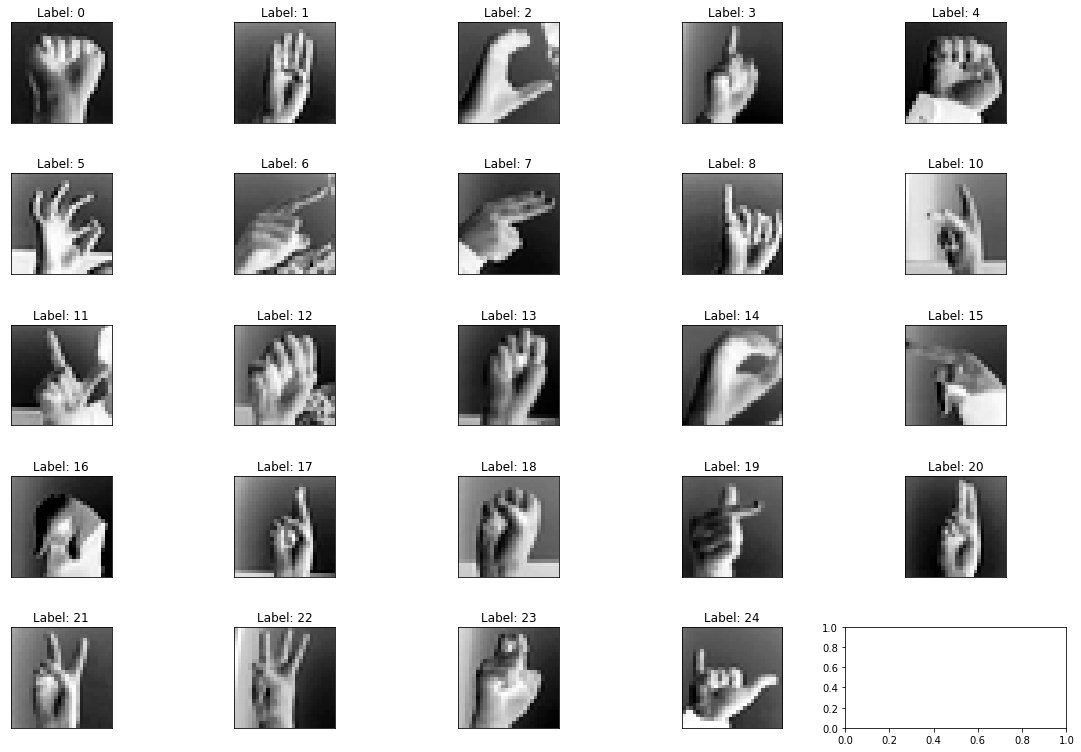

In [3]:
# Returns the index of the first occurence of an item in an array
def find_first(item, array):
    for i in range(len(array)):
        if item == array[i]:
            return i
    return -1

# Converts dataframe to numpy array
np_train_labels = train_labels.values

# Creates an array of all the unique labels
unique_labels = np.unique(np_train_labels)

# Plots all unique handshapes in a 5x5 grid
fig, axs = plt.subplots(5,5,figsize=(20,20))
for i, l in enumerate(unique_labels):
    loc = find_first(l, np_train_labels)
    img_flat = train_features.iloc[loc].values
    img = img_flat.reshape(28,28)
    plt.subplot(5, 5, i+1, xticks=[], yticks=[])
    plt.imshow(img, cmap='Greys')
    plt.title("Label: " + str(l))

plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=0.5, wspace=0.01)
plt.show()

#### PRE-PROCESS DATA

The data has been pre-processed in the following manner:
1. Rescale feature values
2. Create one-hot encoding for labels
3. Create validation dataset from training dataset
4. Reshape input features from 1D arrays into 4D tensors

In [4]:
# Rescales [0,255] --> [0,1]
x_train = train_features.astype('float32')/255
x_test = test_features.astype('float32')/255

# One-hot encode the labels
num_classes = len(unique_labels)+1
y_train = keras.utils.to_categorical(train_labels.values, num_classes)
y_test = keras.utils.to_categorical(test_labels.values, num_classes)

# Breaks training dataset into training and validation datasets
(x_train, x_valid) = x_train[3000:], x_train[:3000]
(y_train, y_valid) = y_train[3000:], y_train[:3000]

# Reshapes training, validation and testing features into 4D tensors
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_valid = x_valid.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

24455 train samples
7172 test samples
3000 validation samples


#### MODEL ARCHITECTURE

The following section explores various models and their corresponding accuracies achieved:
1. Single Layer Perceptron
2. CNN (Multilayer from Scratch)
3. AdaBoost Classifier
4. Support Vector Machines
5. Gaussian Naive Bayes

##### SINGLE LAYER PERCEPTRON

In [5]:
# Creates the model
start = time()
model = Sequential()

model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dropout(0.4))
model.add(Dense(25, activation='softmax'))

model.summary()

# Compiles the model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Trains the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.1_layer', verbose=1, save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=32, epochs=25,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

model.load_weights('model.weights.best.1_layer')
end = time()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                19625     
Total params: 19,625.0
Trainable params: 19,625.0
Non-trainable params: 0.0
_________________________________________________________________
Train on 24455 samples, validate on 3000 samples
Epoch 1/25
Epoch 00000: val_loss improved from inf to 2.51126, saving model to model.weights.best.1_layer
1s - loss: 3.0794 - acc: 0.1209 - val_loss: 2.5113 - val_acc: 0.3347
Epoch 2/25
Epoch 00001: val_loss improved from 2.51126 to 2.15538, saving model to model.weights.best.1_layer
1s - loss: 2.5501 - acc: 0.2525 - val_loss: 2.1554 - val_acc: 

In [6]:
# Predicts and prints accuracy of predictions
y_hat = model.predict(x_test)
test_accuracy = 100*np.sum(np.argmax(y_hat, axis=1)==np.argmax(y_test, axis=1))/len(y_hat)
print('Test accuracy (1-layer perceptron): %.4f%%' % test_accuracy)
print('Time to train: %.2fs' % (end - start))

# Converts probabilities to predicted label
y_test_labels = np.argmax(y_test, axis=1)
y_hat_labels = np.argmax(y_hat, axis=1)

# Save model and labels
perceptron_model = model
perceptron_labels = [y_test_labels, y_hat_labels]

Test accuracy (1-layer perceptron): 55.4099%
Time to train: 39.68s


The single layer perceptron performs decently well achieving an accuracy level of 61%, which is markedly better than random chance, which is 4.2%.

#### CNN (MULTILAYER FROM SCRATCH)

In [7]:
# Creates the model
start = time()
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(25, activation='softmax'))

model.summary()

# Compiles the model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Trains the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.CNN_scratch', verbose=1, save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=32, epochs=25,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

model.load_weights('model.weights.best.CNN_scratch')
end = time()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
__________

In [8]:
# Predicts and prints accuracy of predictions
y_hat = model.predict(x_test)
test_accuracy = 100*np.sum(np.argmax(y_hat, axis=1)==np.argmax(y_test, axis=1))/len(y_hat)
print('Test accuracy (Multilayer CNN from scratch): %.4f%%' % test_accuracy)
print('Time to train: %.2fs' % (end - start))

# Converts probabilities to predicted label
y_test_labels = np.argmax(y_test, axis=1)
y_hat_labels = np.argmax(y_hat, axis=1)

# Save model and labels
multilayerCNN_model = model
multilayerCNN_labels = [y_test_labels, y_hat_labels]

Test accuracy (Multilayer CNN from scratch): 87.5209%
Time to train: 250.36s


The mulitilayer CNN from scratch outperforms the 1-layer perceptron achieving an accuracy level of 81% compared to the single layer perceptron which achieved 61% accuracy.

#### ADABOOST CLASSIFIER

In [9]:
start = time()

# Rescales [0,255] --> [0,1]
x_train = train_features.astype('float32')/255
x_test = test_features.astype('float32')/255
y_train = train_labels.values
y_test = test_labels.values

# Defines classifer
clf = AdaBoostClassifier()
clf = clf.fit(x_train, y_train)
end = time()

# Predicts and prints accuracy of predictions
y_hat_train = clf.predict(x_train)
y_hat_test = clf.predict(x_test)
training_accuracy = accuracy_score(y_train[0:10000], y_hat_train[0:10000])*100
print('Training accuracy (AdaBoost): %.4f%%' % training_accuracy)
testing_accuracy = accuracy_score(y_test, y_hat_test)*100
print('Test accuracy (AdaBoost): %.4f%%' % testing_accuracy)
print('Time to train: %.2fs' % (end - start))

# Save model and labels
adaboost_clf = clf
adaboost_labels = [y_test, y_hat_test]

Training accuracy (AdaBoost): 34.5100%
Test accuracy (AdaBoost): 31.5533%
Time to train: 48.93s


The default AdaBoost classifier only achieves 31.6% accuracy on the testing dataset which is much lower than what the  multilayer CNN and single layer perceptron achieved.

#### SVC CLASSIFIER

In [10]:
start = time()

# Rescales [0,255] --> [0,1]
x_train = train_features.astype('float32')/255
x_test = test_features.astype('float32')/255
y_train = train_labels.values
y_test = test_labels.values

# Defines classifer
clf = SVC()
clf = clf.fit(x_train, y_train)
end = time()

# Predicts and prints accuracy of predictions
y_hat_train = clf.predict(x_train)
y_hat_test = clf.predict(x_test)
training_accuracy = accuracy_score(y_train[0:10000], y_hat_train[0:10000])*100
print('Training accuracy (SVC): %.4f%%' % training_accuracy)
testing_accuracy = accuracy_score(y_test, y_hat_test)*100
print('Test accuracy (SVC): %.4f%%' % testing_accuracy)
print('Time to train: %.2fs' % (end - start))

# Save model and labels
SVC_clf = clf
SVC_labels = [y_test, y_hat_test]

Training accuracy (SVC): 84.1500%
Test accuracy (SVC): 69.6877%
Time to train: 478.94s


The default SVC classifier achieves 70% accuracy on the testing dataset which is lower than what the  multilayer CNN achieved but is higher than what the single layer perceptron and default AdaBoost classifier achieved.

#### GAUSSIAN NAIVE BAYES

In [11]:
start = time()

# Rescales [0,255] --> [0,1]
x_train = train_features.astype('float32')/255
x_test = test_features.astype('float32')/255
y_train = train_labels.values
y_test = test_labels.values

# Defines classifer
clf = GaussianNB()
clf = clf.fit(x_train, y_train)
end = time()

# Predicts and prints accuracy of predictions
y_hat_train = clf.predict(x_train)
y_hat_test = clf.predict(x_test)
training_accuracy = accuracy_score(y_train[0:10000], y_hat_train[0:10000])*100
print('Training accuracy (GaussianNB): %.4f%%' % training_accuracy)
testing_accuracy = accuracy_score(y_test, y_hat_test)*100
print('Test accuracy (GaussianNB): %.4f%%' % testing_accuracy)
print('Time to train: %.2fs' % (end - start))

# Save model and labels
gaussianNB_clf = clf
gaussianNB_labels = [y_test, y_hat_test]

Training accuracy (GaussianNB): 45.7300%
Test accuracy (GaussianNB): 38.9849%
Time to train: 0.63s


The default GaussianNB classifier only achieves 39% accuracy on the testing dataset which is lower than what all the other models achieved except the AdaBoost classifier. However, it has the shortest training time. 

#### OPTIMIZED SVC

Since the SVC model achieved the best out of all the supervised learning classifiers, I used GridSearchCV to find the optimal parameters and improved its accuracy.

In [12]:
start = time()
# Initializes the classifier
clf = SVC()

# Defines parameter list to tune
parameters = {'C': [0.5, 0.75, 1.25, 1.5], 'gamma' : [0.0001, 0.001, 0.01, 0.1]}

# Defines scoring method
scorer = make_scorer(accuracy_score)

# Performs grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid = parameters,scoring=scorer)
grid_fit = grid_obj.fit(x_train, y_train)
end = time()

# Get the best estimator
best_clf = grid_fit.best_estimator_

# Predicts and prints accuracy of predictions
y_hat_test = best_clf.predict(x_test)
testing_accuracy = accuracy_score(y_test, y_hat_test)*100
print('Test accuracy (SVC Optimized): %.4f%%' % testing_accuracy)
print('Time to train: %.2fs' % (end - start))

OptimizedSVC_clf = best_clf
OptimizedSVC_labels = [y_test, y_hat_test]
print(OptimizedSVC_clf)

Test accuracy (SVC Optimized): 84.4813%
Time to train: 17124.27s
SVC(C=1.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### CONFUSION MATRIX

The confusion below helps to identify the hand gestures that tend to get misclassified the most

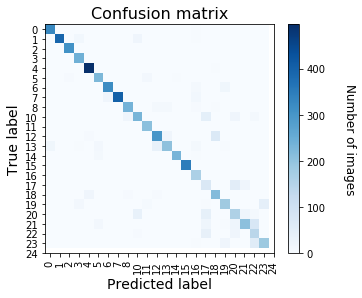

In [13]:
# Creates and saves confusion matrix into a csv file
def save_confusion_matrix(labels):
    matrix = np.zeros((len(unique_labels)+1, len(unique_labels)+1))
    i = 0
    while i < len(labels[0]):
        matrix[labels[0][i]][labels[1][i]]+=1
        i += 1
    np.savetxt("confusion_matrix.csv", matrix, delimiter=",")
    return matrix

# Plots confusion matrix
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array[:-1,:-1], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.show()
    
save_confusion_matrix(multilayerCNN_labels)
plot_confusion_matrix(multilayerCNN_labels[0], multilayerCNN_labels[1])

#### TEST IMAGES

Runs multilayer CNN and Optimized SVC model against test images (images provided in Kaggle dataset as well as random images from the internet) to check accuracy

In [14]:
def image_detector(img_path):

    # Plots original image after being shrunk to 28x28 target size
    img = image.load_img(img_path, target_size=(28,28))
    plt.imshow(img)
    plt.show()
    
    # Converts image to grayscale
    img = np.asarray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Multilayer CNN predicts label of image
    x = image.img_to_array(img)
    x = x.astype('float32')/255
    x_img = np.expand_dims(x, axis=0)
    label = np.argmax(multilayerCNN_model.predict(x_img))
    print("CNN Multilayer: ", label)
    
    # Optimized SVC predicts label of image
    x = img.flatten()
    x_img = x.astype('float32')/255
    label = OptimizedSVC_clf.predict(x_img)
    print("Optimized SVC Prediction: ", label)


Filename: testImages\color\A[0].png


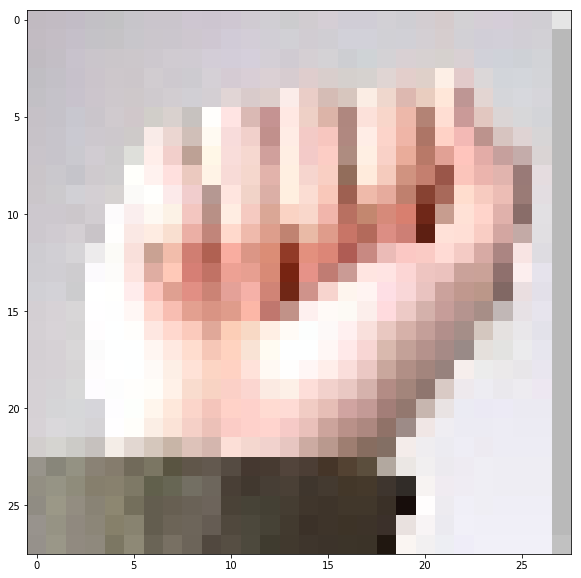

CNN Multilayer:  0
Optimized SVC Prediction:  [13]

Filename: testImages\color\B[1].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


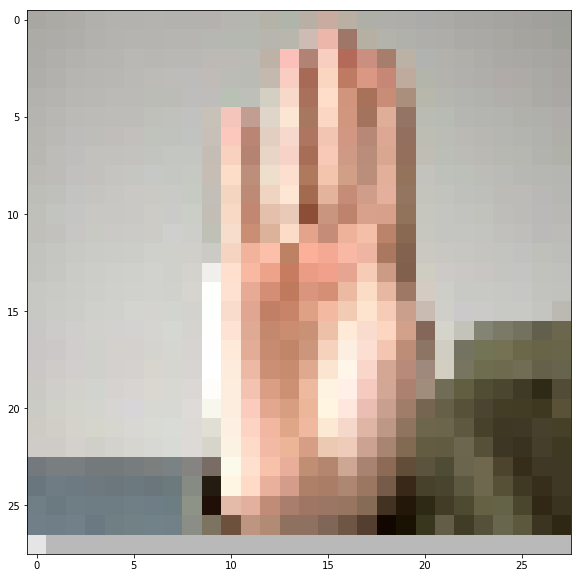

CNN Multilayer:  1
Optimized SVC Prediction:  [1]

Filename: testImages\color\C[2].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


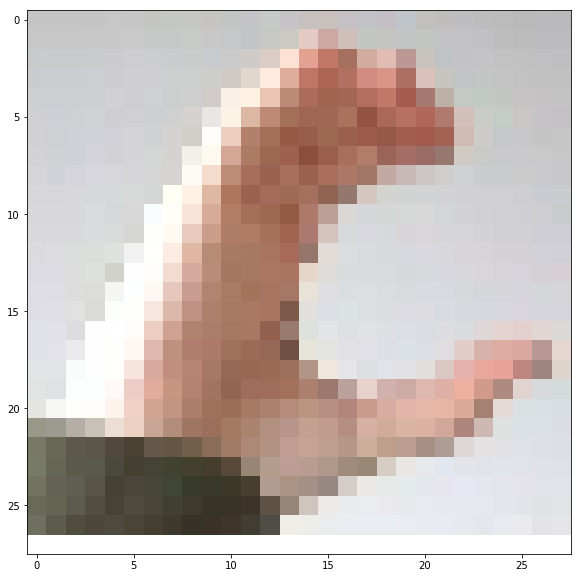

CNN Multilayer:  2
Optimized SVC Prediction:  [2]

Filename: testImages\color\D[3].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


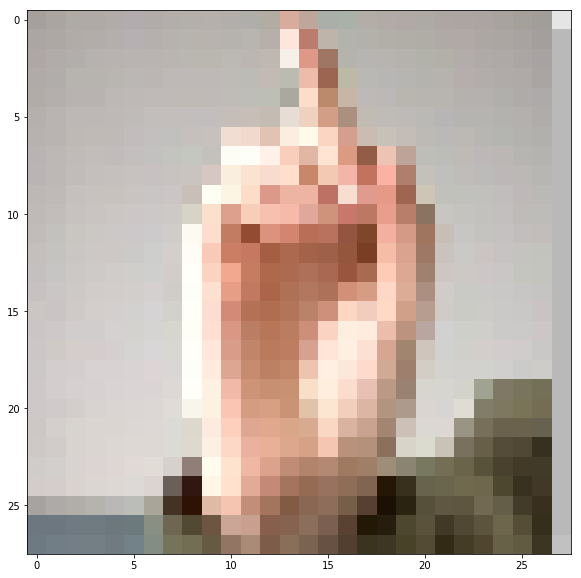

CNN Multilayer:  3
Optimized SVC Prediction:  [3]

Filename: testImages\color\E[4].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


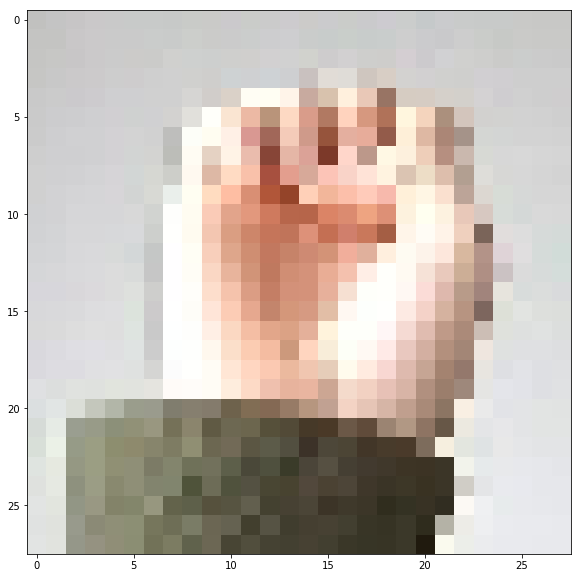

CNN Multilayer:  4
Optimized SVC Prediction:  [4]

Filename: testImages\color\F[5].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


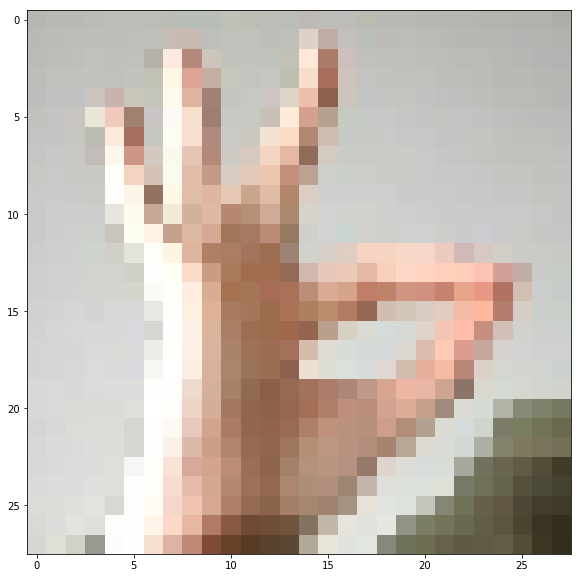

CNN Multilayer:  5
Optimized SVC Prediction:  [5]

Filename: testImages\color\G[6].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


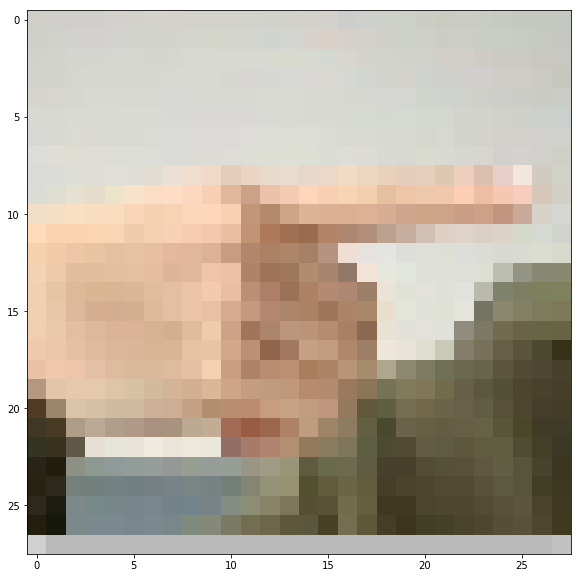

CNN Multilayer:  6
Optimized SVC Prediction:  [6]

Filename: testImages\color\H[7].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


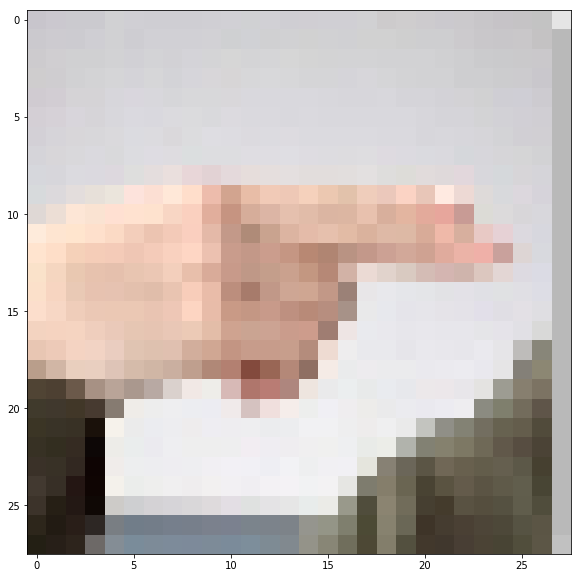

CNN Multilayer:  7
Optimized SVC Prediction:  [7]

Filename: testImages\color\I[8].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


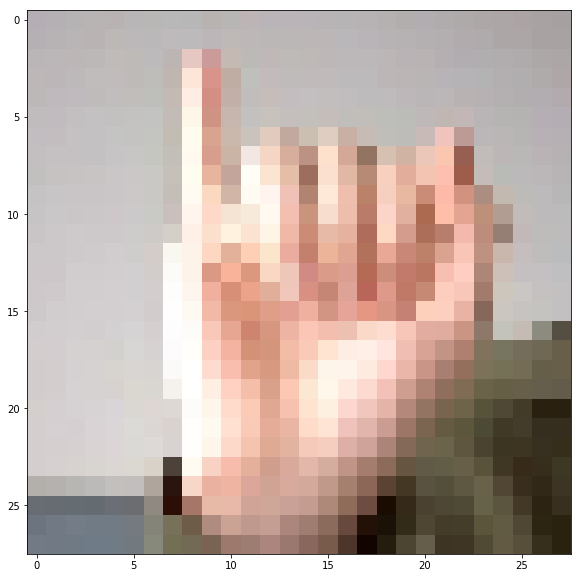

CNN Multilayer:  8
Optimized SVC Prediction:  [8]

Filename: testImages\color\K[10].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


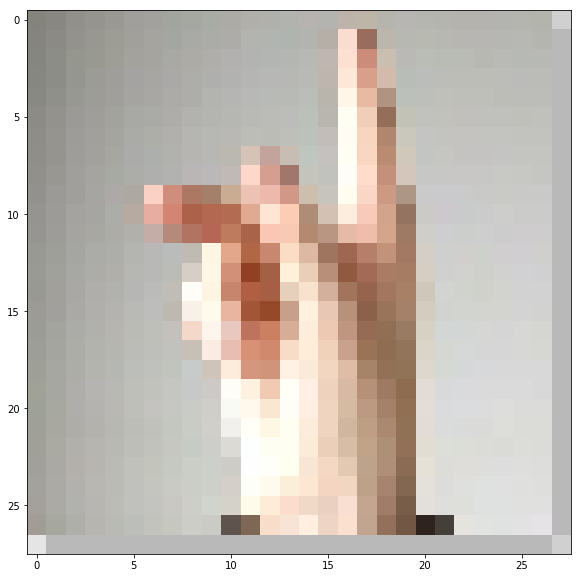

CNN Multilayer:  10
Optimized SVC Prediction:  [10]

Filename: testImages\color\L[11].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


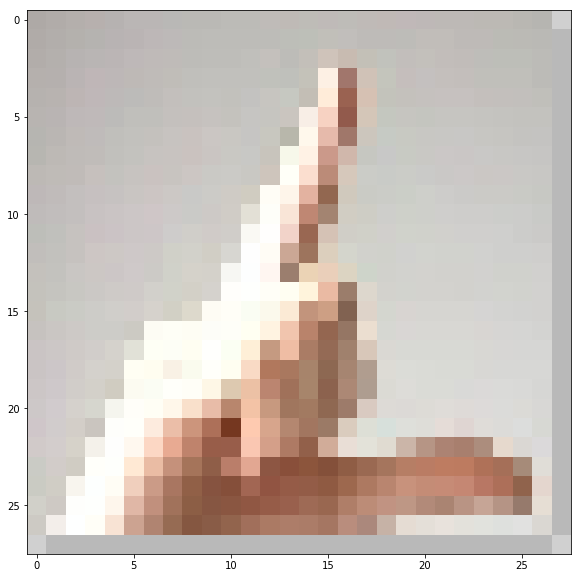

CNN Multilayer:  11
Optimized SVC Prediction:  [11]

Filename: testImages\color\M[12].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


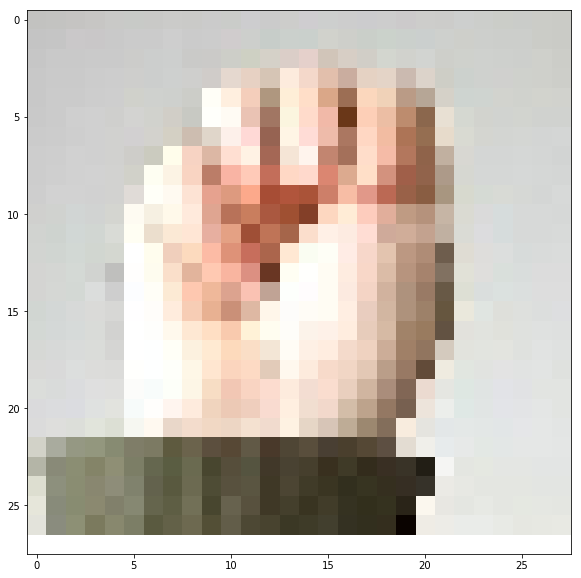

CNN Multilayer:  12
Optimized SVC Prediction:  [13]

Filename: testImages\color\N[13].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


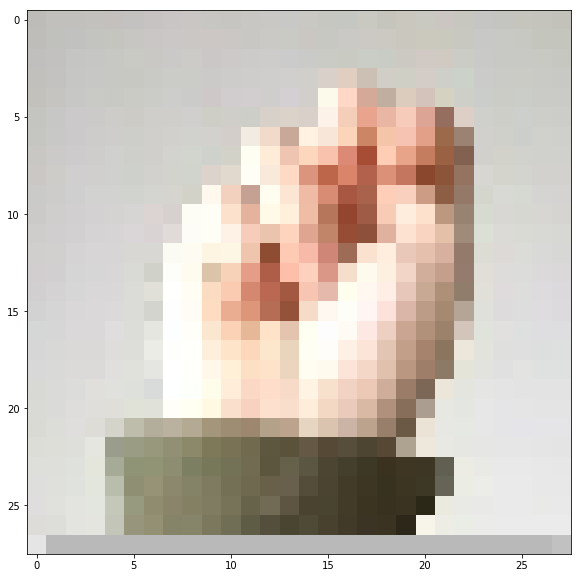

CNN Multilayer:  13
Optimized SVC Prediction:  [13]

Filename: testImages\color\O[14].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


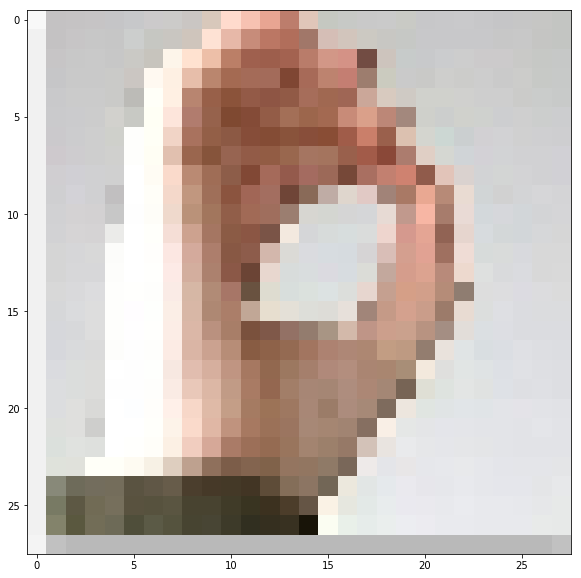

CNN Multilayer:  14
Optimized SVC Prediction:  [14]

Filename: testImages\color\P[15].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


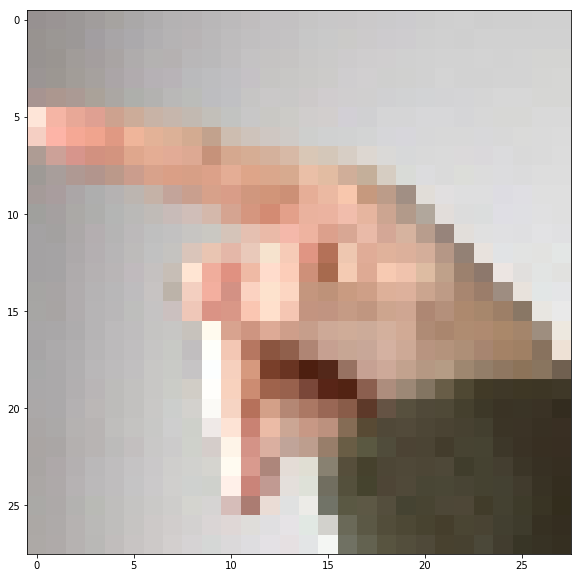

CNN Multilayer:  15
Optimized SVC Prediction:  [15]

Filename: testImages\color\Q[16].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


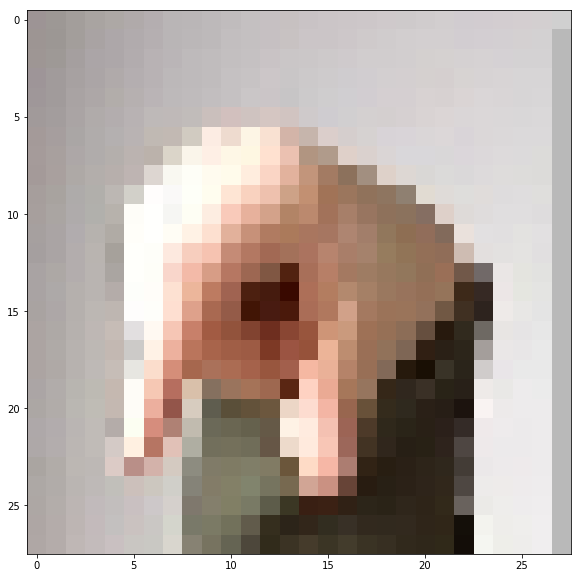

CNN Multilayer:  16
Optimized SVC Prediction:  [16]

Filename: testImages\color\R[17].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


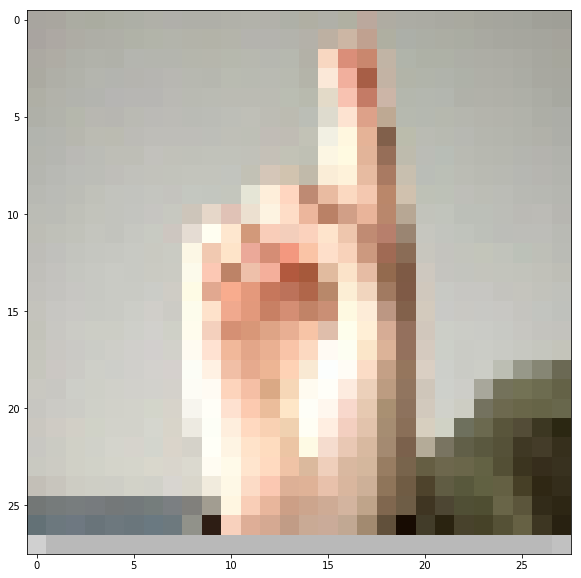

CNN Multilayer:  17
Optimized SVC Prediction:  [17]

Filename: testImages\color\T[18].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


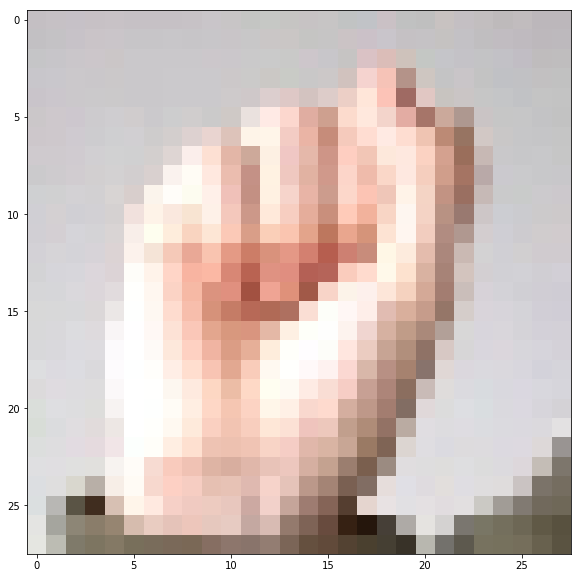

CNN Multilayer:  18
Optimized SVC Prediction:  [18]

Filename: testImages\color\T[19].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


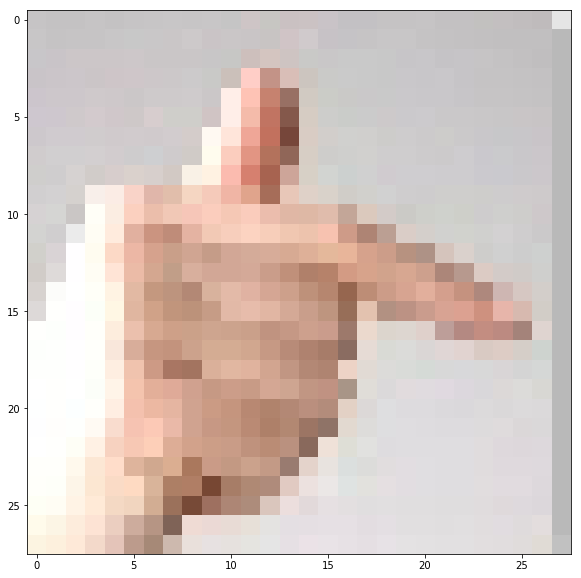

CNN Multilayer:  19
Optimized SVC Prediction:  [19]

Filename: testImages\color\U[20].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


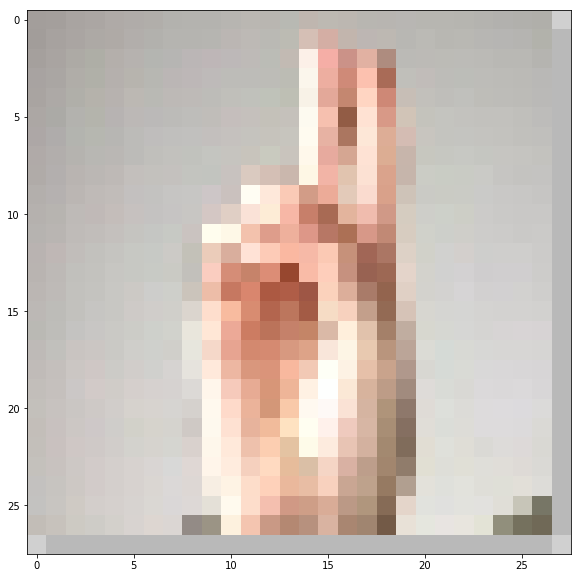

CNN Multilayer:  20
Optimized SVC Prediction:  [20]

Filename: testImages\color\V[21].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


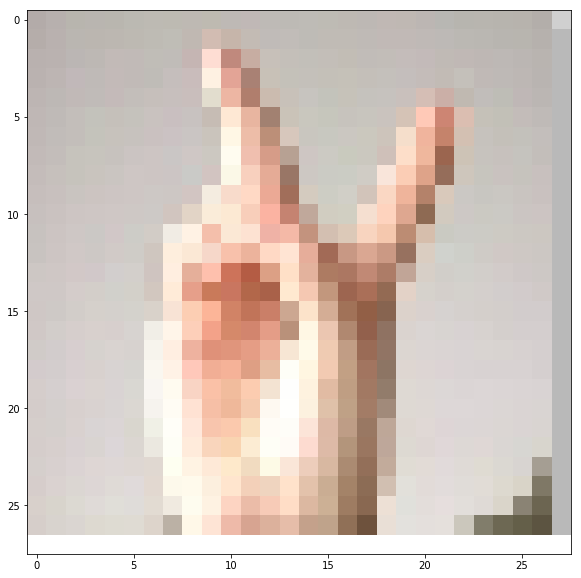

CNN Multilayer:  21
Optimized SVC Prediction:  [21]

Filename: testImages\color\W[22].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


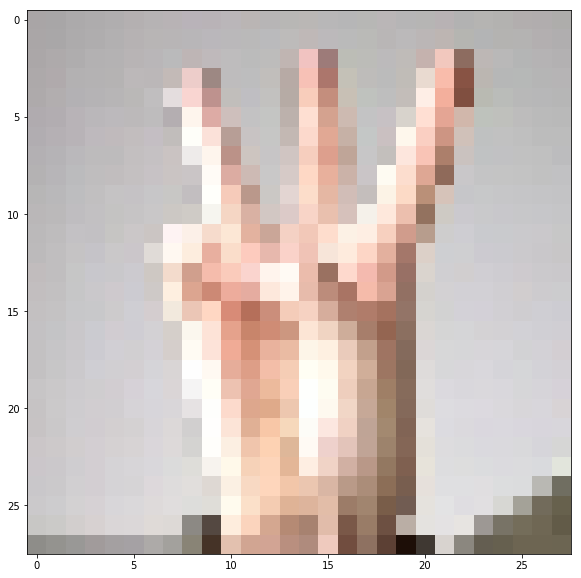

CNN Multilayer:  22
Optimized SVC Prediction:  [22]

Filename: testImages\color\X[23].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


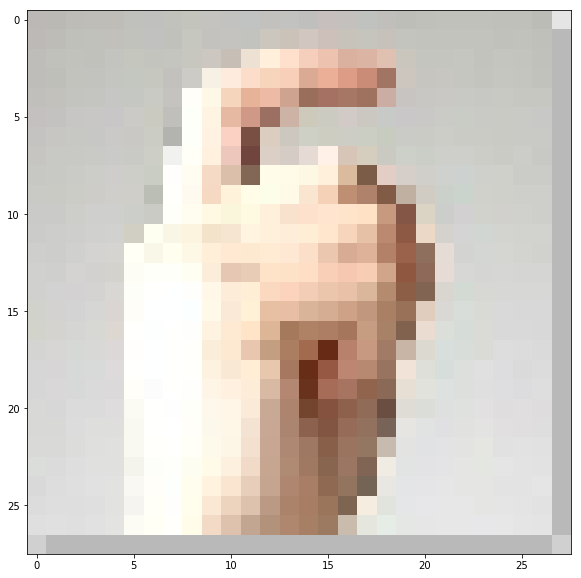

CNN Multilayer:  23
Optimized SVC Prediction:  [23]

Filename: testImages\color\Y[24].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


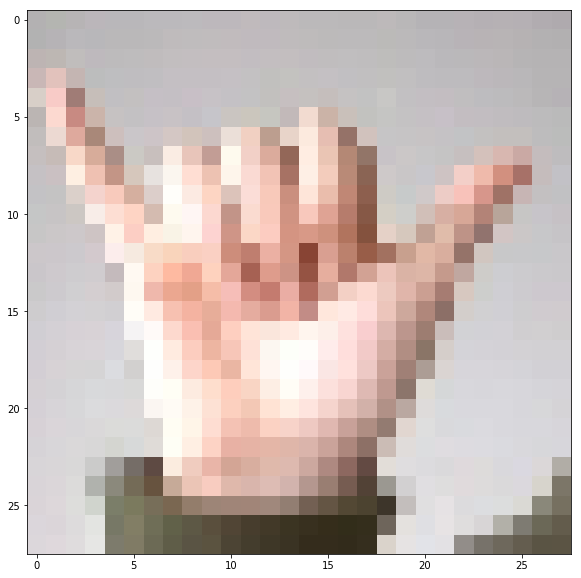

CNN Multilayer:  24
Optimized SVC Prediction:  [24]


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [15]:
# Tests color images provided in Kaggle dataset
test_files = np.array(glob("testImages\color\*"))

for img in test_files:
    print("\nFilename: " + img)
    image_detector(img)


Filename: testImages\internetImages\C[2].png


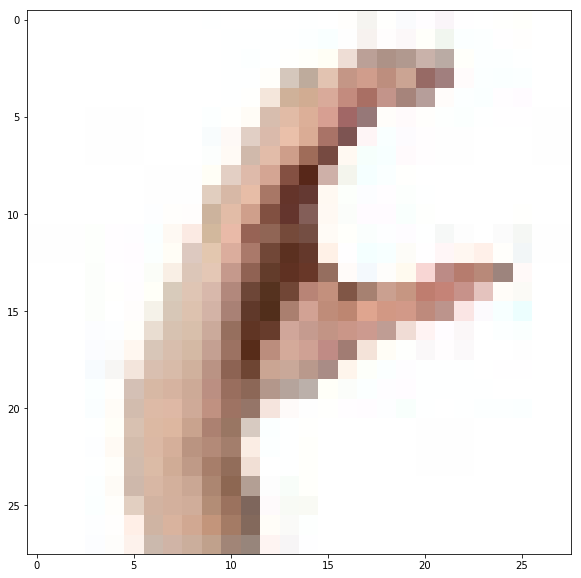

CNN Multilayer:  14
Optimized SVC Prediction:  [16]

Filename: testImages\internetImages\D[4].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


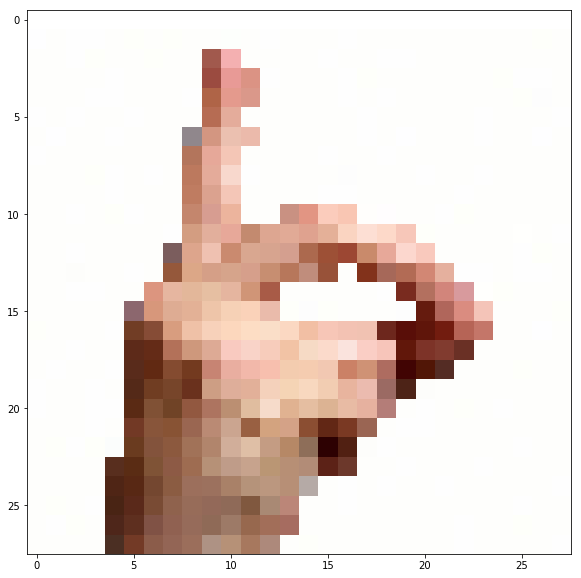

CNN Multilayer:  24
Optimized SVC Prediction:  [16]

Filename: testImages\internetImages\I[8].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


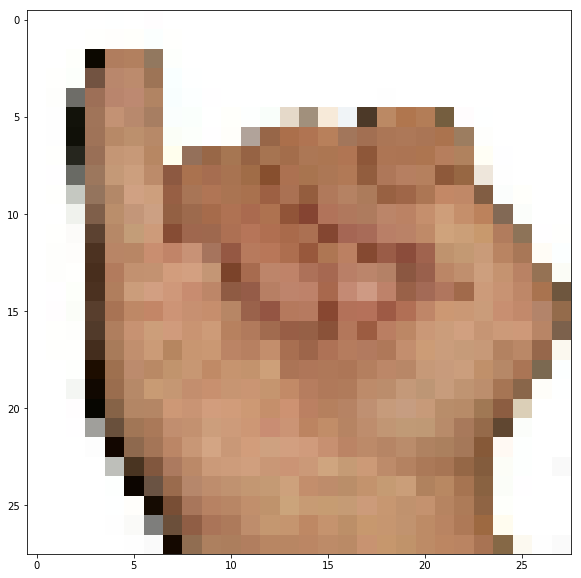

CNN Multilayer:  0
Optimized SVC Prediction:  [16]

Filename: testImages\internetImages\L[11].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


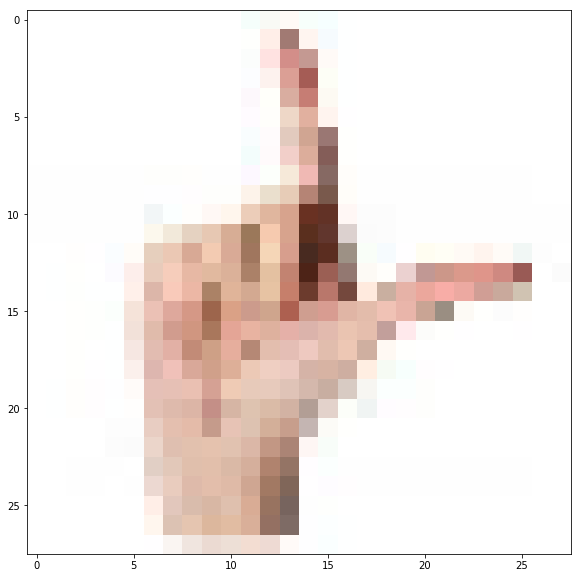

CNN Multilayer:  19
Optimized SVC Prediction:  [19]

Filename: testImages\internetImages\M[12].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


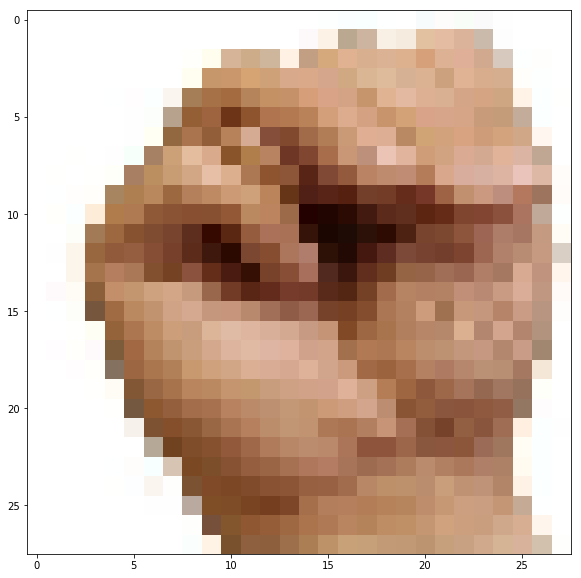

CNN Multilayer:  0
Optimized SVC Prediction:  [16]

Filename: testImages\internetImages\O[14].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


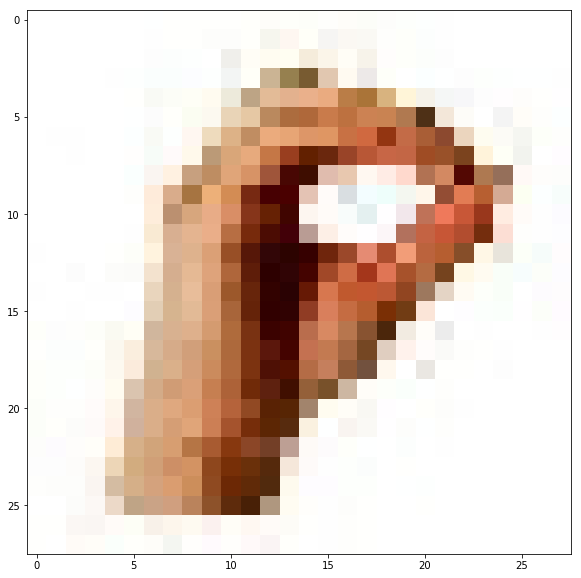

CNN Multilayer:  19
Optimized SVC Prediction:  [16]

Filename: testImages\internetImages\U[20].png


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


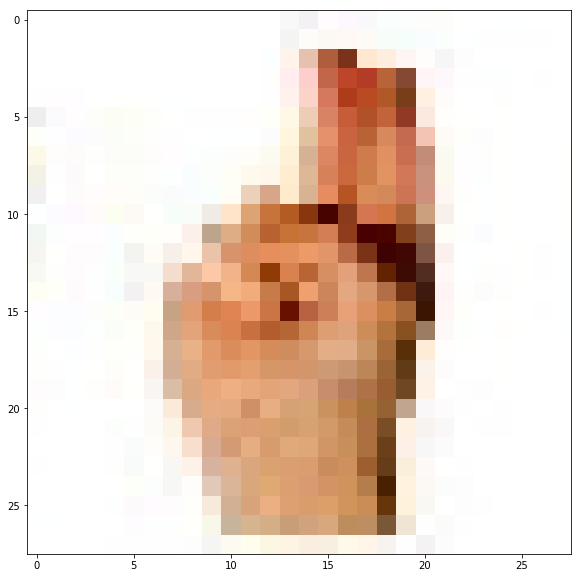

CNN Multilayer:  13
Optimized SVC Prediction:  [16]

Filename: testImages\internetImages\V[21].jpg


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


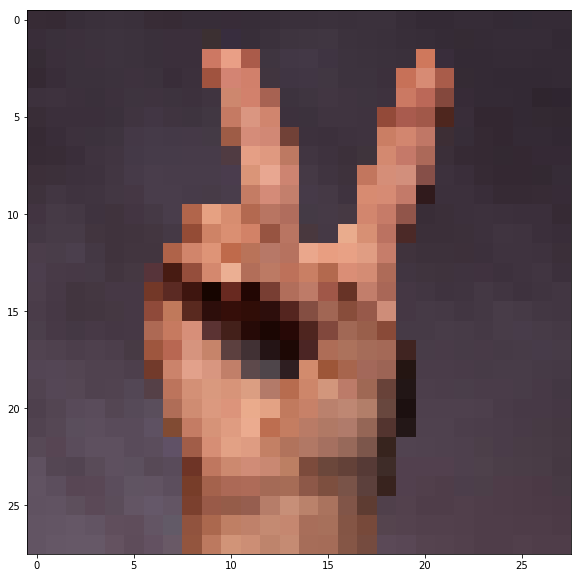

CNN Multilayer:  11
Optimized SVC Prediction:  [16]


C:\Users\Darryl\Anaconda3\envs\dog-project\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [16]:
# Tests images from internet
test_files = np.array(glob("testImages\internetImages\*"))

for img in test_files:
    print("\nFilename: " + img)
    image_detector(img)